In [1]:
# Copyright 2020 NVIDIA Corporation. All Rights Reserved.
#
# Licensed under the Apache License, Version 2.0 (the "License");
# you may not use this file except in compliance with the License.
# You may obtain a copy of the License at
#
#     http://www.apache.org/licenses/LICENSE-2.0
#
# Unless required by applicable law or agreed to in writing, software
# distributed under the License is distributed on an "AS IS" BASIS,
# WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
# See the License for the specific language governing permissions and
# limitations under the License.
# ==============================================================================

<img src="http://developer.download.nvidia.com/compute/machine-learning/frameworks/nvidia_logo.png" style="width: 90px; float: right;">

# TRTorch - SSD Object Detection

---
## Overview


In PyTorch 1.0, TorchScript was introduced as a method to separate your PyTorch model from Python, make it portable and optimizable.

TRTorch is a compiler that uses TensorRT (NVIDIA's Deep Learning Optimization SDK and Runtime) to optimize TorchScript code. It compiles standard TorchScript modules into ones that internally run with TensorRT optimizations.

TensorRT can take models from any major framework and specifically tune them to perform better on specific target hardware in the NVIDIA family, and TRTorch enables us to continue to remain in the PyTorch ecosystem whilst doing so. This allows us to leverage the great features in PyTorch, including module composability, its flexible tensor implementation, data loaders and more. TRTorch is available to use with both PyTorch and LibTorch. 

To get more background information on this, we suggest the **lenet-getting-started** notebook as a primer for getting started with TRTorch.

### Learning objectives

This notebook demonstrates the steps for compiling a TorchScript module with TRTorch on a pretrained SSD network, and running it to test the speedup obtained.

## Contents
1. [Requirements](#1)
2. [SSD Overview](#2)
3. [Creating TorchScript modules](#3)
4. [Compiling with TRTorch](#4)
5. [Running Inference](#5)
6. [Measuring Speedup](#6)
7. [Conclusion](#7)

---
<a id="1"></a>
## 1. Requirements

Follow the steps in `notebooks/README` to prepare a Docker container, within which you can run this demo notebook.

In addition to that, run the following cell to obtain additional libraries specific to this demo.

In [2]:
%%capture 
%%bash
# Known working versions
pip install numpy==1.19 scipy==1.5.2 Pillow==6.2.0 scikit-image==0.17.2 matplotlib==3.3.0

---
<a id="2"></a>
## 2. SSD

### Single Shot MultiBox Detector model for object detection

_ | _
- | -
![alt](https://pytorch.org/assets/images/ssd_diagram.png) | ![alt](https://pytorch.org/assets/images/ssd.png)

PyTorch has a model repository called the PyTorch Hub, which is a source for high quality implementations of common models. We can get our SSD model pretrained on [COCO](https://cocodataset.org/#home) from there.

### Model Description

This SSD300 model is based on the
[SSD: Single Shot MultiBox Detector](https://arxiv.org/abs/1512.02325) paper, which
describes SSD as “a method for detecting objects in images using a single deep neural network".
The input size is fixed to 300x300.

The main difference between this model and the one described in the paper is in the backbone.
Specifically, the VGG model is obsolete and is replaced by the ResNet-50 model.

From the
[Speed/accuracy trade-offs for modern convolutional object detectors](https://arxiv.org/abs/1611.10012)
paper, the following enhancements were made to the backbone:
*   The conv5_x, avgpool, fc and softmax layers were removed from the original classification model.
*   All strides in conv4_x are set to 1x1.

The backbone is followed by 5 additional convolutional layers.
In addition to the convolutional layers, we attached 6 detection heads:
*   The first detection head is attached to the last conv4_x layer.
*   The other five detection heads are attached to the corresponding 5 additional layers.

Detector heads are similar to the ones referenced in the paper, however,
they are enhanced by additional BatchNorm layers after each convolution.

More information about this SSD model is available at Nvidia's "DeepLearningExamples" Github [here](https://github.com/NVIDIA/DeepLearningExamples/tree/master/PyTorch/Detection/SSD).

In [3]:
import torch

# List of available models in PyTorch Hub from Nvidia/DeepLearningExamples
torch.hub.list('NVIDIA/DeepLearningExamples:torchhub')

Using cache found in /root/.cache/torch/hub/NVIDIA_DeepLearningExamples_torchhub


['checkpoint_from_distributed',
 'nvidia_ncf',
 'nvidia_ssd',
 'nvidia_ssd_processing_utils',
 'nvidia_tacotron2',
 'nvidia_waveglow',
 'unwrap_distributed']

In [4]:
# load SSD model pretrained on COCO from Torch Hub
precision = 'fp32'
ssd300 = torch.hub.load('NVIDIA/DeepLearningExamples:torchhub', 'nvidia_ssd', model_math=precision);

Using cache found in /root/.cache/torch/hub/NVIDIA_DeepLearningExamples_torchhub


Setting `precision="fp16"` will load a checkpoint trained with mixed precision 
into architecture enabling execution on Tensor Cores. Handling mixed precision data requires the Apex library.

### Benchmark utility

In [5]:
import time
import numpy as np

import torch.backends.cudnn as cudnn
cudnn.benchmark = True

# Helper function to benchmark the model
def benchmark(model, input_shape=(1024, 1, 32, 32), dtype='fp32', nwarmup=50, nruns=10000):
    input_data = torch.randn(input_shape)
    input_data = input_data.to("cuda")
    if dtype=='fp16':
        input_data = input_data.half()
        
    print("Warm up ...")
    with torch.no_grad():
        for _ in range(nwarmup):
            features = model(input_data)
    torch.cuda.synchronize()
    print("Start timing ...")
    timings = []
    with torch.no_grad():
        for i in range(1, nruns+1):
            start_time = time.time()
            pred_loc, pred_label  = model(input_data)
            torch.cuda.synchronize()
            end_time = time.time()
            timings.append(end_time - start_time)
            if i%1000==0:
                print('Iteration %d/%d, ave batch time %.2f ms'%(i, nruns, np.mean(timings)*1000))

    print("Input shape:", input_data.size())
    print("Output location prediction size:", pred_loc.size())
    print("Output label prediction size:", pred_label.size())
    print('Average batch time: %.2f ms'%(np.mean(timings)*1000))


In [6]:
# Model benchmark without TRTorch/TensorRT
model = ssd300.eval().to("cuda")
benchmark(model, input_shape=(128, 3, 300, 300), nruns=5000)

Warm up ...
Start timing ...
Iteration 1000/5000, ave batch time 366.77 ms
Iteration 2000/5000, ave batch time 366.99 ms
Iteration 3000/5000, ave batch time 367.04 ms
Iteration 4000/5000, ave batch time 367.05 ms
Iteration 5000/5000, ave batch time 367.07 ms
Input shape: torch.Size([128, 3, 300, 300])
Output location prediction size: torch.Size([128, 4, 8732])
Output label prediction size: torch.Size([128, 81, 8732])
Average batch time: 367.07 ms


---
<a id="3"></a>
## 3. Creating TorchScript modules  

To compile with TRTorch, the model must first be in **TorchScript**. TorchScript is a programming language included in PyTorch which removes the Python dependency normal PyTorch models have. This conversion is done via a JIT compiler which given a PyTorch Module will generate an equivalent TorchScript Module. There are two paths that can be used to generate TorchScript: **Tracing** and **Scripting**. Tracing follows execution of PyTorch generating ops in TorchScript corresponding to what it sees. Scripting does an analysis of the Python code and generates TorchScript, this allows the resulting graph to include control flow which tracing cannot do. Tracing however due to its simplicity is more likely to compile successfully with TRTorch (though both systems are supported).

In [7]:
model = ssd300.eval().to("cuda")
traced_model = torch.jit.trace(model, [torch.randn((1,3,300,300)).to("cuda")])

We can save this model and use it independently of Python.

In [8]:
# This is just an example, and not required for the purposes of this demo
torch.jit.save(traced_model, "ssd_300_traced.jit.pt")

In [9]:
# Obtain the average time taken by a batch of input
benchmark(traced_model, input_shape=(128, 3, 300, 300), nruns=5000)

Warm up ...
Start timing ...
Iteration 1000/5000, ave batch time 366.47 ms
Iteration 2000/5000, ave batch time 366.43 ms
Iteration 3000/5000, ave batch time 366.42 ms
Iteration 4000/5000, ave batch time 366.43 ms
Iteration 5000/5000, ave batch time 366.42 ms
Input shape: torch.Size([128, 3, 300, 300])
Output location prediction size: torch.Size([128, 4, 8732])
Output label prediction size: torch.Size([128, 81, 8732])
Average batch time: 366.42 ms


---
<a id="4"></a>
## 4. Compiling with TRTorch
TorchScript modules behave just like normal PyTorch modules and are intercompatable. From TorchScript we can now compile a TensorRT based module. This module will still be implemented in TorchScript but all the computation will be done in TensorRT.

In [10]:
import trtorch

trt_model = trtorch.compile(traced_model, {
    "input_shapes": [(3, 3, 300, 300)],
    "op_precision": torch.half,
    "workspace_size": 1 << 20
})

---
<a id="5"></a>
## 5. Running Inference

We can now run inference on the TRTorch compiled model. This is demonstrated below using sample images from the COCO 2017 Validation set.

In [11]:
# Sample images from the COCO validation set
uris = [
    'http://images.cocodataset.org/val2017/000000397133.jpg',
    'http://images.cocodataset.org/val2017/000000037777.jpg',
    'http://images.cocodataset.org/val2017/000000252219.jpg'
]

# For convenient and comprehensive formatting of input and output of the model, load a set of utility methods.
utils = torch.hub.load('NVIDIA/DeepLearningExamples:torchhub', 'nvidia_ssd_processing_utils')

# Format images to comply with the network input
inputs = [utils.prepare_input(uri) for uri in uris]
tensor = utils.prepare_tensor(inputs, False)

# The model was trained on COCO dataset, which we need to access in order to
# translate class IDs into object names. 
classes_to_labels = utils.get_coco_object_dictionary()

Using cache found in /root/.cache/torch/hub/NVIDIA_DeepLearningExamples_torchhub


In [12]:
# Run object detection
detections_batch = trt_model(tensor.to(torch.half))

By default, raw output from SSD network per input image contains 8732 boxes with localization and class probability distribution. Let’s filter this output to only get reasonable detections (confidence>40%) in a more comprehensive format.

In [13]:
results_per_input = utils.decode_results(detections_batch)
best_results_per_input = [utils.pick_best(results, 0.40) for results in results_per_input]

Now, let's visualize our predictions!


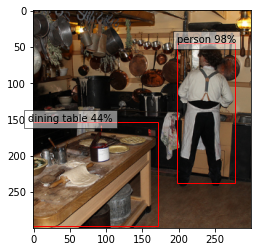

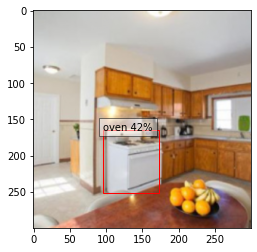

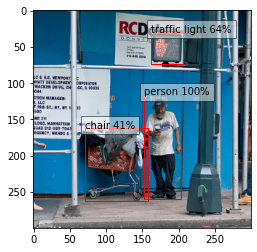

In [14]:
# Plotting the images and predicted bounding boxes (with confidence scores).
from matplotlib import pyplot as plt
import matplotlib.patches as patches

for image_idx in range(len(best_results_per_input)):
    fig, ax = plt.subplots(1)
    # Show original, denormalized image...
    image = inputs[image_idx] / 2 + 0.5
    ax.imshow(image)
    # ...with detections
    bboxes, classes, confidences = best_results_per_input[image_idx]
    for idx in range(len(bboxes)):
        left, bot, right, top = bboxes[idx]
        x, y, w, h = [val * 300 for val in [left, bot, right - left, top - bot]]
        rect = patches.Rectangle((x, y), w, h, linewidth=1, edgecolor='r', facecolor='none')
        ax.add_patch(rect)
        ax.text(x, y, "{} {:.0f}%".format(classes_to_labels[classes[idx] - 1], confidences[idx]*100), bbox=dict(facecolor='white', alpha=0.5))
plt.show()

---
## 6. Measuring Speedup
We can run the benchmark again utility to see the speedup gained! Compare this result with the average time taken by a similar sized batch of input in the case without TRTorch/TRT above.

In [15]:
benchmark(trt_model, input_shape=(128, 3, 300, 300), nruns=5000, dtype="fp16")

Warm up ...
Start timing ...
Iteration 1000/5000, ave batch time 3.31 ms
Iteration 2000/5000, ave batch time 3.30 ms
Iteration 3000/5000, ave batch time 3.30 ms
Iteration 4000/5000, ave batch time 3.30 ms
Iteration 5000/5000, ave batch time 3.30 ms
Input shape: torch.Size([128, 3, 300, 300])
Output location prediction size: torch.Size([3, 4, 8732])
Output label prediction size: torch.Size([3, 81, 8732])
Average batch time: 3.30 ms


---
## 7. Conclusion

In this notebook, we have walked through the complete process of compiling a TorchScript SSD300 model with TRTorch, and tested the performance impact of the optimization.

### Details
For detailed information on model input and output,
training recipies, inference and performance visit:
[github](https://github.com/NVIDIA/DeepLearningExamples/tree/master/PyTorch/Detection/SSD)
and/or [NGC](https://ngc.nvidia.com/catalog/model-scripts/nvidia:ssd_for_pytorch)

### References

 - [SSD: Single Shot MultiBox Detector](https://arxiv.org/abs/1512.02325) paper
 - [Speed/accuracy trade-offs for modern convolutional object detectors](https://arxiv.org/abs/1611.10012) paper
 - [SSD on NGC](https://ngc.nvidia.com/catalog/model-scripts/nvidia:ssd_for_pytorch)
 - [SSD on github](https://github.com/NVIDIA/DeepLearningExamples/tree/master/PyTorch/Detection/SSD)